In [6]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

%matplotlib inline

# Helpers

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
def adf_test(df, response, alpha=0.05, autolag='AIC'):
    series = pd.to_numeric(df[response], errors='coerce').dropna()

    adf_stat, pval, lags, nobs, crit, _ = adfuller(series, autolag=autolag)

    is_stationary = pval < alpha

    if is_stationary:
        reason = (f'Stationary: ADF p-value={pval:.4g} < {alpha} so reject the null hypothesis')
    else:
        reason = (f'Non-stationary: ADF p-value={pval:.4g} >= {alpha} so fail to reject the null hypothesis')

    return reason

# Datasets

## AMD

In [6]:
df_amd = pd.read_csv('data/AMD.csv', parse_dates=['Date'], index_col='Date')
print(df_amd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10098 non-null  float64
 1   High       10098 non-null  float64
 2   Low        10098 non-null  float64
 3   Close      10098 non-null  float64
 4   Adj Close  10098 non-null  float64
 5   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.2 KB
None


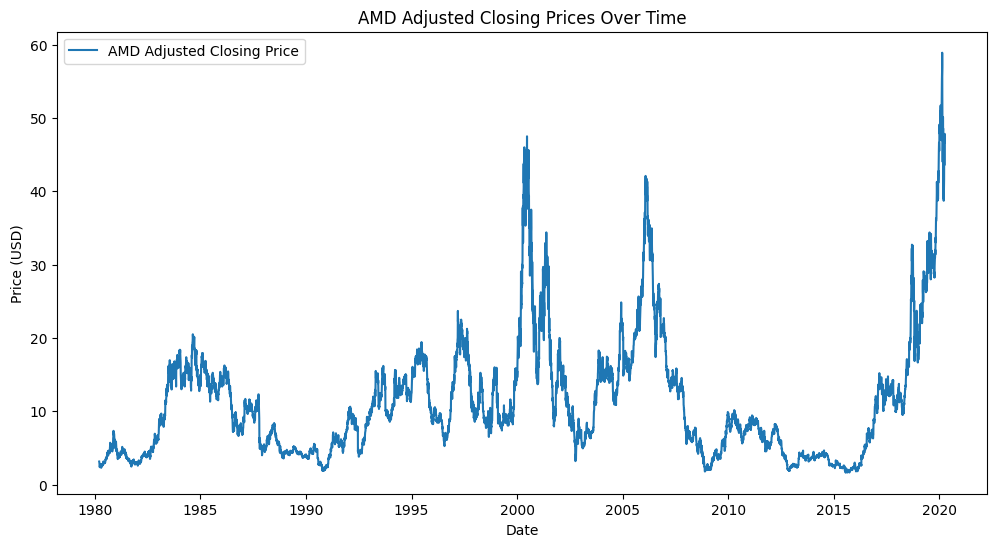

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df_amd['Adj Close'], label='AMD Adjusted Closing Price')
plt.title('AMD Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [9]:
print(adf_test(df_amd, 'Adj Close'))

Non-stationary: ADF p-value=0.05468 >= 0.05 so fail to reject the null hypothesis


## Air Quality

In [22]:
df_air = pd.read_csv('data/AirQualityUCI.csv', sep=';', decimal=',', na_values=[-200, '-200'])
df_air = df_air.loc[:, ~df_air.columns.str.contains("^Unnamed")]
print(df_air.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB
None


In [23]:
ts = pd.to_datetime(
    df_air['Date'].astype(str).str.strip() + ' ' + df_air['Time'].astype(str).str.replace('.', ':', regex=False),
    dayfirst=True,
    errors='coerce'
)

df_air.insert(0, 'timestamp', ts)
df_air = df_air.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True) # drop bad timestamps
df_air = df_air.set_index('timestamp').sort_index()

df_air = df_air.drop(columns=['Date', 'Time'])

In [24]:
df_air.dropna(subset='CO(GT)')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
timestamp,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


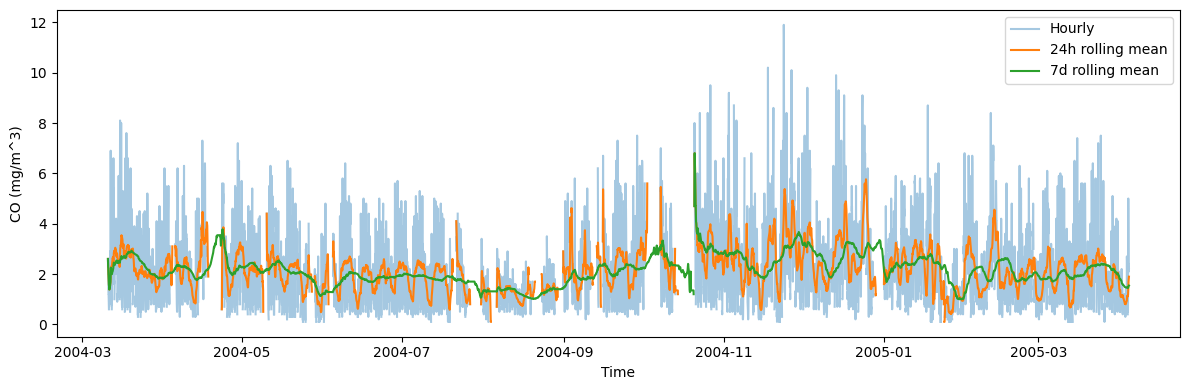

In [ ]:
df_air['CO_24h_mean'] = df_air['CO(GT)'].rolling(24, min_periods=1).mean()
df_air['CO_7d_mean']  = df_air['CO(GT)'].rolling(24*7, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_air.index, df_air['CO(GT)'], alpha=0.4, label='Hourly')
plt.plot(df_air.index, df_air['CO_24h_mean'], label='24h rolling mean')
plt.plot(df_air.index, df_air['CO_7d_mean'], label='7d rolling mean')
plt.title('Air Quality Over Time')
plt.xlabel('Time')
plt.ylabel('CO (mg/m^3)')
plt.legend()
plt.tight_layout()
# plt.savefig('air_q_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [26]:
print(adf_test(df_air, 'CO(GT)'))

Stationary: ADF p-value=2.498e-16 < 0.05 so reject the null hyptothesis


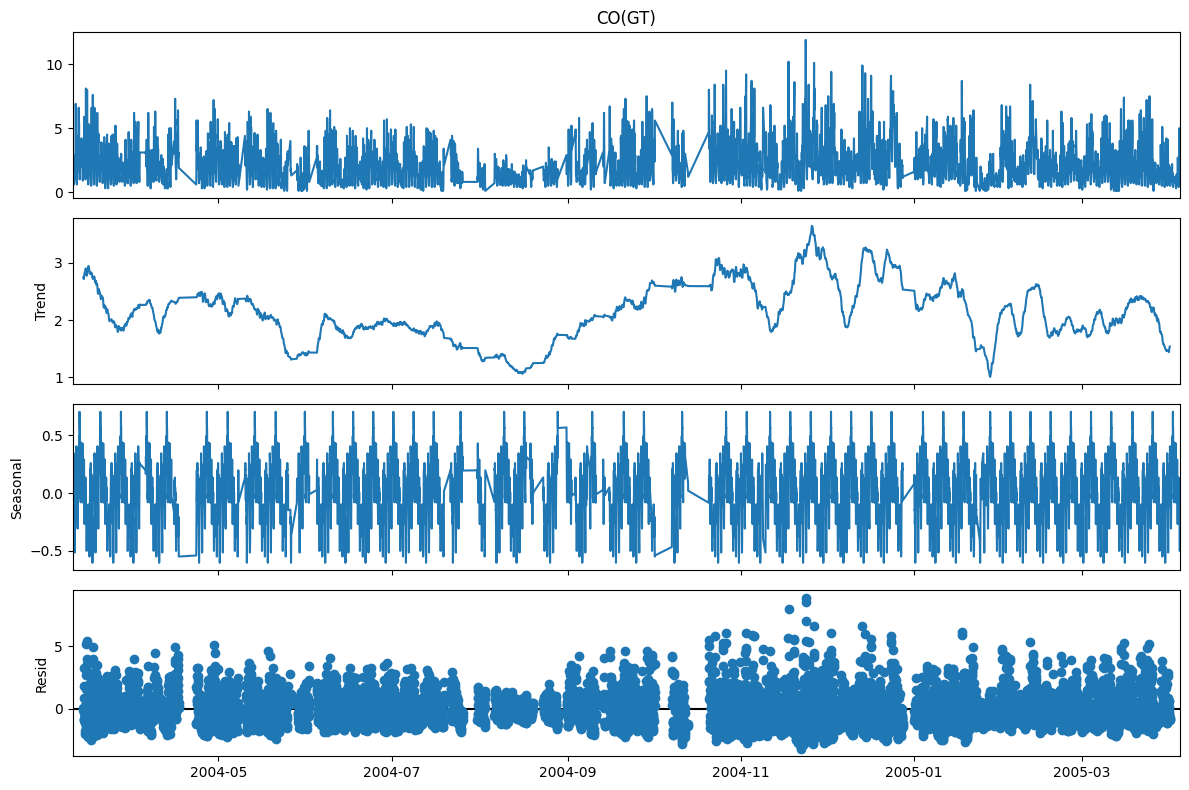

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_air['CO(GT)'].dropna(), model='additive', period=24*7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
#plt.savefig('air_q_seasonal.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## Garment Productivity

In [40]:
df_prod = pd.read_csv('data/garments_worker_productivity.csv')
df_prod.columns = [c.strip().lower() for c in df_prod.columns]

df_prod['department'] = (
    df_prod['department']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({'sweing': 'sewing', 'finishing ': 'finishing'})
)

df_prod['date'] = pd.to_datetime(df_prod['date'], dayfirst=False, errors='coerce')
df_prod = df_prod.dropna(subset=['date', 'actual_productivity']).copy()

df_prod = df_prod.sort_values('date').set_index('date')

print(df_prod.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1197 entries, 2015-01-01 to 2015-03-11
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
mem

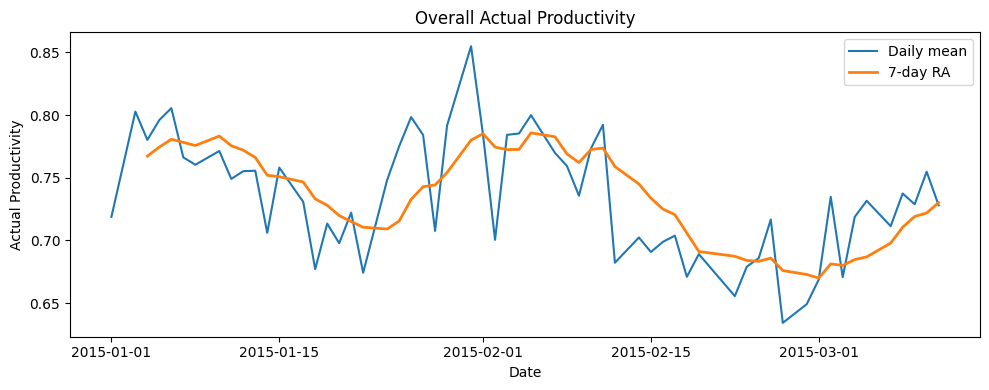

In [49]:
overall = (
    df_prod
    .groupby(pd.Grouper(freq='D'))['actual_productivity']
    .mean()
    .dropna()
)

overall_smooth = overall.rolling(window=7, min_periods=3).mean()

plt.figure(figsize=(10, 4))
plt.plot(overall.index, overall.values, label='Daily mean')
plt.plot(overall_smooth.index, overall_smooth.values, label='7-day RA', linewidth=2)
plt.title('Overall Actual Productivity')
plt.xlabel('Date')
plt.ylabel('Actual Productivity')
plt.legend()
plt.tight_layout()
# plt.savefig('actual_prod.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [41]:
print(adf_test(df_prod, 'actual_productivity'))

Stationary: ADF p-value=0.001457 < 0.05 so reject the null hyptothesis


## Occupancy

In [68]:
paths = [
    'data/occupancy/datatraining.txt',
    'data/occupancy/datatest.txt',
    'data/occupancy/datatest2.txt',
]

dfs = []
for path in paths:
    df = pd.read_csv(path)
    df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed")]
    dfs.append(df)

df_occupy = pd.concat(dfs, ignore_index=True) # combine dataframes

ts = pd.to_datetime(
    df_occupy['date'].astype(str).str.strip(),
    errors='coerce'
)

df_occupy.insert(0, 'timestamp', ts)
df_occupy = df_occupy.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True)
df_occupy = df_occupy.set_index('timestamp').sort_index()
df_occupy = df_occupy.drop(columns=['date'])

print(df_occupy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20560 entries, 2015-02-02 14:19:00 to 2015-02-18 09:19:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    20560 non-null  float64
 1   Humidity       20560 non-null  float64
 2   Light          20560 non-null  float64
 3   CO2            20560 non-null  float64
 4   HumidityRatio  20560 non-null  float64
 5   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.1 MB
None


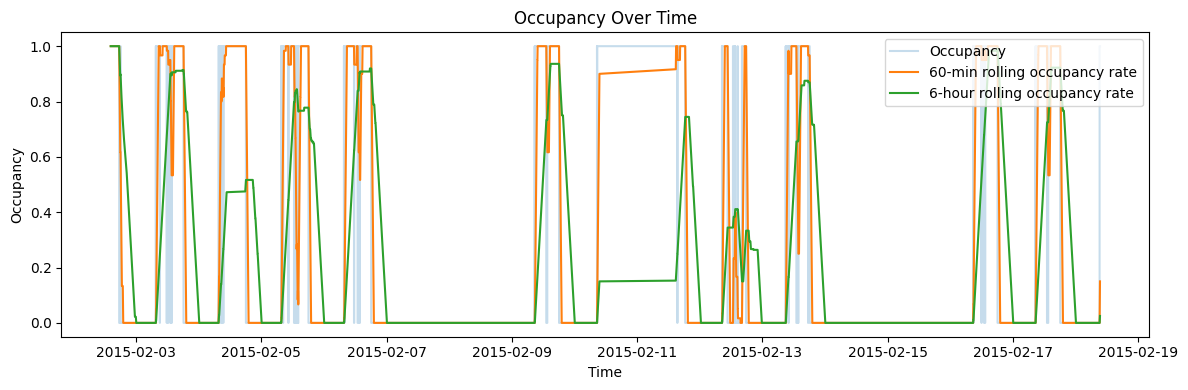

In [69]:
occ_60m_mean = df_occupy['Occupancy'].rolling(60, min_periods=1).mean()
occ_6h_mean  = df_occupy['Occupancy'].rolling(60 * 6,  min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_occupy.index, df_occupy['Occupancy'], drawstyle='steps-pre', alpha=0.25, label='Occupancy')
plt.plot(df_occupy.index, occ_60m_mean, label='60-min rolling occupancy rate')
plt.plot(df_occupy.index, occ_6h_mean,  label='6-hour rolling occupancy rate')
plt.title('Occupancy Over Time')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('occupancy_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


In [70]:
print(adf_test(df_occupy, 'Occupancy'))

Stationary: ADF p-value=5.08e-09 < 0.05 so reject the null hyptothesis


## Weather

In [78]:
df_weather = pd.read_csv('data/weather.csv', parse_dates=['date'], index_col='date')
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52696 entries, 2020-01-01 00:10:00 to 2021-01-01 00:00:00
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p         52696 non-null  float64
 1   T         52696 non-null  float64
 2   Tpot      52696 non-null  float64
 3   Tdew      52696 non-null  float64
 4   rh        52696 non-null  float64
 5   VPmax     52696 non-null  float64
 6   VPact     52696 non-null  float64
 7   VPdef     52696 non-null  float64
 8   sh        52696 non-null  float64
 9   H2OC      52696 non-null  float64
 10  rho       52696 non-null  float64
 11  wv        52696 non-null  float64
 12  max. wv   52696 non-null  float64
 13  wd        52696 non-null  float64
 14  rain      52696 non-null  float64
 15  raining   52696 non-null  float64
 16  SWDR      52696 non-null  float64
 17  PAR       52696 non-null  float64
 18  max. PAR  52696 non-null  float64
 19  Tlog      52696 non-null  float6

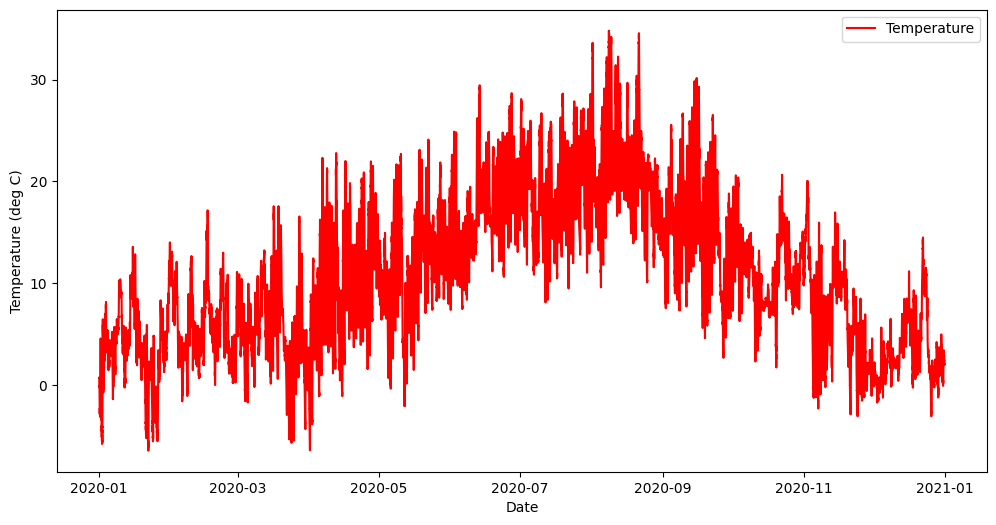

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_weather['T'], label='Temperature', color='red')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (deg C)')
plt.legend()
# plt.savefig('temp_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [77]:
print(adf_test(df_weather, 'T'))

Stationary: ADF p-value=2.149e-13 < 0.05 so reject the null hyptothesis


# RNNs

## Elman

In [3]:
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences):
        super().__init__()
        self.hidden_size = hidden_size
        self.return_sequences = return_sequences # sequence-to-one vs sequence-to-sequence

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = x.new_zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)

        if self.return_sequences:
           return self.fc(out)
        else:
            return self.fc(out[:, -1, :])

## Jordan

In [4]:
class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences, output_activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.return_sequences = return_sequences
        self.output_activation = output_activation # identity, sigmoid, softmax, tanh

        self.xh = nn.Linear(input_size, hidden_size, bias=True)
        self.yh = nn.Linear(output_size, hidden_size, bias=False)
        self.hy = nn.Linear(hidden_size, output_size, bias=True)
    
    def _activate(self, y):
        if self.output_activation == 'identity':
            return y
        
        if self.output_activation == 'sigmoid':
            return torch.sigmoid(y)
        
        if self.output_activation == 'softmax':
            return nn.functional.softmax(y, dim=-1)
        
        if self.output_activation == 'tanh':
            return torch.tanh(y)
        
    def forward(self, x):
        B, T, _ = x.shape

        y_prev = torch.zeros(B, self.output_size, device=x.device, dtype=x.dtype)
        y_prev_act = self._activate(y_prev)
        ys = []

        for t in range(T):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.xh(x_t) + self.yh(y_prev_act))
            y_t = self.hy(h_t)
            ys.append(y_t)
            y_prev_act = self._activate(y_t) # update
        
        y_seq = torch.stack(ys, dim=1)
        
        if self.return_sequences:
            return y_seq
        else:
            return y_seq[:, -1, :]

## Multi-RNN

In [5]:
# FOllows same pattern as above
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, return_sequences, output_activation):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.return_sequences = return_sequences
        self.output_activation = output_activation

        self.xh = nn.Linear(input_size, hidden_size, bias=True)
        self.hh = nn.Linear(hidden_size, hidden_size, bias=False) # Elman Part
        self.yh = nn.Linear(output_size, hidden_size, bias=False) # Jordan Part
        self.hy = nn.Linear(hidden_size, output_size, bias=True)

    def _activate(self, y):
        if self.output_activation == 'identity':
            return y
        
        if self.output_activation == 'sigmoid':
            return torch.sigmoid(y)
        
        if self.output_activation == 'softmax':
            return nn.functional.softmax(y, dim=-1)
        
        if self.output_activation == 'tanh':
            return torch.tanh(y)
        
    def forward(self, x):
        B, T, _ = x.shape

        h_prev = torch.zeros(B, self.hidden_size, device=x.device, dtype=x.dtype)
        y_prev = torch.zeros(B, self.output_size, device=x.device, dtype=x.dtype)
        y_prev_act = self._activate(y_prev)

        ys = []
        for t in range(T):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.xh(x_t), self.hh(h_prev) + self.yh(y_prev_act))
            y_t = self.hy(h_t)
            ys.append(y_t)

            # update recurrences
            h_prev = h_t
            y_prev_act = self._activate(y_t)

        y_seq = torch.stack(ys, dim=1)
        
        if self.return_sequences:
            return y_seq
        else:
            return y_seq[:, -1, :]